<a href="https://colab.research.google.com/github/rguezzdani/Machine-Learning/blob/master/06MBIG_AG2_PrediccionDengue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Descripción del problema**
Este problema se basa en realizar una predicción de contagios de Dengue por semana en dos ciudades (San Juan e Iquitos) a través de datos meteorológicos. Estas predicciones son para presentar en una competición en la página web DrivenData y estos errores serán medidos por la misma mediante el error absoluto medio (mae).

# **2. Técnicas utilizadas**
### 1. DecisionTree

### 2. K nearest neighbors (KNN)

# **3. Resolución del problema**

## 1. DecisionTree

Cargando datos y librerías

In [0]:
# carga de datos
import pandas as pd
import io
from google.colab import files
# manipulación y visualización
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns

#sklearn
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

In [0]:
def upload_files ():
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
    return df

Subimos los datos de entrenamiento sin campo objetivo (dengue_features_train)

In [0]:
train_feat = upload_files()
train_feat.head()

Saving dengue_features_train.csv to dengue_features_train (2).csv
User uploaded file "dengue_features_train.csv" with length 287139 bytes


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


Subimos los datos del campo objetivo (número de casos de dengue para las semanas de entrenamiento) (dengue_labels_train)

In [0]:
train_labels = upload_files()
train_labels.head()

Saving dengue_labels_train.csv to dengue_labels_train (2).csv
User uploaded file "dengue_labels_train.csv" with length 19582 bytes


,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


Mezclamos los dos conjuntos de datos para tenerlos en un unico dataframe

In [0]:
train = pd.merge(train_feat,train_labels,on=['city', 'year', 'weekofyear'])
train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


Finalmente subimos los datos de test sobre los que haremos la predicción y generaremos un fichero para subir a la competición, donde obtendremos el error que hemos tenido (dengue_features_test)

In [0]:
test = upload_files()
test.head()

Saving dengue_features_test.csv to dengue_features_test (8).csv
User uploaded file "dengue_features_test.csv" with length 82465 bytes


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


Preproceso

In [0]:
train.drop("week_start_date", axis = 1, inplace = True)
test.drop("week_start_date", axis = 1, inplace = True)
train.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [0]:
pd.isnull(train).any()

city                                     False
year                                     False
weekofyear                               False
ndvi_ne                                   True
ndvi_nw                                   True
ndvi_se                                   True
ndvi_sw                                   True
precipitation_amt_mm                      True
reanalysis_air_temp_k                     True
reanalysis_avg_temp_k                     True
reanalysis_dew_point_temp_k               True
reanalysis_max_air_temp_k                 True
reanalysis_min_air_temp_k                 True
reanalysis_precip_amt_kg_per_m2           True
reanalysis_relative_humidity_percent      True
reanalysis_sat_precip_amt_mm              True
reanalysis_specific_humidity_g_per_kg     True
reanalysis_tdtr_k                         True
station_avg_temp_c                        True
station_diur_temp_rng_c                   True
station_max_temp_c                        True
station_min_t

In [0]:
# ffill: propagate last valid observation forward to next valid backfill
# Otra Opción: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate
train.fillna(method='ffill', inplace=True)
pd.isnull(train).any()

city                                     False
year                                     False
weekofyear                               False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_t

In [0]:
test.fillna(method='ffill', inplace=True)
pd.isnull(test).any()

city                                     False
year                                     False
weekofyear                               False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_t

También tenemos que transformar nuestras variables categóricas, en este caso una única variable que es la ciudad y, como solo hay dos, vamos a utilizar un *binarizador* para train y para test

In [0]:
lb = preprocessing.LabelBinarizer()
train['city_bin'] = lb.fit_transform(train['city'])
test['city_bin'] = lb.fit_transform(test['city'])

train.drop(['city'], axis = 1, inplace=True)
test.drop(['city'], axis = 1, inplace=True)
train.drop(['year'], axis = 1, inplace=True)
test.drop(['year'], axis = 1, inplace=True)

Utilizamos la función SelectKBest de sklearn.feature_selection con la función de evaluación f_regressor para seleccionar las características más importantes para nuestro modelo.

In [0]:
k = 8
columnas = list(train.drop(['total_cases'], axis=1).columns.values)
seleccionadas = SelectKBest(f_regression, k = k).fit(train.drop(['total_cases'], axis=1), train['total_cases'])
atrib = seleccionadas.get_support()
atributos = [columnas[i] for i in list(atrib.nonzero()[0])]
atributos

['weekofyear',
 'ndvi_se',
 'reanalysis_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_tdtr_k',
 'station_diur_temp_rng_c',
 'station_min_temp_c',
 'city_bin']

In [0]:
selected_features = atributos.copy()
selected_features.append('total_cases')

x_train = train[selected_features]

In [0]:
test = test[atributos]
test

,weekofyear,ndvi_se,reanalysis_air_temp_k,reanalysis_min_air_temp_k,reanalysis_tdtr_k,station_diur_temp_rng_c,station_min_temp_c,city_bin
0,18,0.102729,298.492857,296.4,3.128571,7.057143,21.7,1
1,19,0.082043,298.475714,296.7,2.571429,5.557143,22.2,1
2,20,0.151083,299.455714,296.4,4.428571,7.785714,22.8,1
3,21,0.124329,299.690000,296.9,4.342857,6.271429,24.4,1
4,22,0.062267,299.780000,297.3,3.542857,7.085714,23.3,1
...,...,...,...,...,...,...,...,...
411,22,0.280629,297.774286,292.7,10.100000,9.050000,21.8,0
412,23,0.285371,297.167143,291.6,9.657143,10.720000,21.4,0
413,24,0.252586,295.831429,290.7,7.385714,10.075000,21.6,0
414,25,0.406614,295.778571,292.5,8.228571,8.480000,21.8,0


Comprobamos qué tal se comporta nuestro árbol de decision con los datos de entrenamiento.

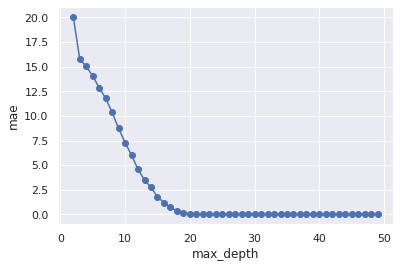

In [0]:
mae = []
for i in range(2, 50):
    regressor = DecisionTreeRegressor(max_depth=i)
    regressor.fit(x_train.drop(['total_cases'], axis=1), x_train['total_cases'])
    pred_values = regressor.predict(x_train.drop(['total_cases'], axis=1))
    maev = mean_absolute_error(x_train['total_cases'],pred_values)
    mae.append(maev)
    
plt.plot(range(2,50), mae, marker='o')
plt.xlabel('max_depth')
plt.ylabel('mae')
plt.show()

Como se puede observar, a partir de una profundidad = 20, aproximadamente, el árbol empieza a sobreaprender por lo que realizaremos validación cruzada con distintas profundidades, entre 2 y 20.

También comprobaremos con valores de min_samples_leaf y min_samples_split entre 2 y 6. 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Max_depth.min_samples_leaf.min_samples_split
18.91227293386726  4.5.2


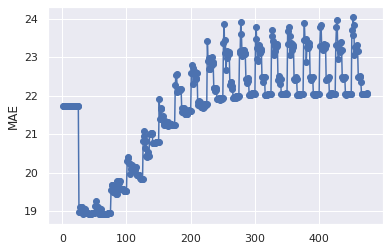

In [0]:
cv = KFold(n_splits = 10, shuffle = False, random_state=0) # 

total_scores= []
depths = range(2,21)
mins_samples_leaf = range(2,7)
mins_samples_split = range(2,7)
combinaciones = []

for i in depths:
  for min_samples_leaf in mins_samples_leaf:
    for min_samples_split in mins_samples_split:
      regressor = DecisionTreeRegressor(max_depth = i, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
      fold_accuracy = []
      combinaciones.append(str(i)+'.'+str(min_samples_leaf) +'.'+ str(min_samples_split))

      for train_fold, test_fold in cv.split(x_train):
        f_train = x_train.loc[train_fold]
        f_test = x_train.loc[test_fold]
        regressor.fit(X = f_train.drop(['total_cases'], axis = 1), y = f_train['total_cases'])
        y_pred = regressor.predict(X = f_test.drop(['total_cases'], axis = 1))
        mae = mean_absolute_error(f_test['total_cases'], y_pred)
        fold_accuracy.append(mae)
      total_scores.append(sum(fold_accuracy)/ len(fold_accuracy))

print('             Max_depth.min_samples_leaf.min_samples_split')
print(str(min(total_scores)) + '  ' + str(combinaciones[total_scores.index(min(total_scores)) ]))


plt.plot(range(1,len(total_scores)+1), total_scores, 
         marker='o')
plt.ylabel('MAE')   

plt.show() 

Obtenemos un mae de 18.91 en la validación cruzada con max_depth = 4, min_samples_leaf = 5 y min_samples_split = 2. Por lo tanto procedemos a realizar las predicciones y a subirlas a la competición a ver qué tan buenos son nuestros resultados con estos parámetros. 

Cabe destacar que se obtienen valores muy parecidos con distintos parámetros, por lo que sería muy interesante probar con esos parámetros y subirlos a la competición, ya que es posible que se puedan obtener mejores resultados que con los parámetros que actualmente vamos a realizar la predicción.

In [0]:
regressor = DecisionTreeRegressor(max_depth = 4, min_samples_leaf=5, min_samples_split= 2)

regressor.fit( X = x_train.drop(['total_cases'], axis=1), y = x_train['total_cases'])

y_pred = regressor.predict(X = test)

res = np.rint(y_pred)
res = res.astype(int)
res

array([13, 13,  8,  8, 14, 17, 17, 17, 17, 17, 17, 17, 59, 59, 42, 41, 59,
       59, 59, 42, 59, 42, 42, 59, 42, 42, 41, 59, 42, 42, 42, 39, 39, 42,
       39, 26, 26, 41, 26, 26, 26, 26, 26, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 17, 17, 14, 17, 17, 17, 17, 17, 59, 42, 59, 59,
       59, 59, 59, 42, 41, 42, 59, 59, 59, 59, 59, 59, 42, 42, 42, 42, 42,
       42, 42, 42, 26, 26, 26, 26, 26, 14, 14, 26, 17, 13, 13, 13, 17, 13,
       13, 13, 14, 17, 17, 17, 17, 14, 17, 17, 17, 17, 17, 17, 41, 42, 59,
       41, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 42, 42, 42, 39, 42, 39,
       39, 39, 39, 39, 26, 26, 26, 26, 26, 26, 26, 26, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 17, 14, 17, 17, 17, 17, 17, 17, 59,
       42, 42, 42, 59, 42, 59, 59, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
       42, 42, 42, 39, 39, 41, 26, 26, 26, 26, 26, 26, 26, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 14, 13, 14, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       59, 59, 59, 41, 59

In [0]:
test = upload_files()
test.head()

Saving dengue_features_test.csv to dengue_features_test (9).csv
User uploaded file "dengue_features_test.csv" with length 82465 bytes


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


Generamos el fichero de salida para subirlo a la competición

In [0]:
output = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': res})

from google.colab import files

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('result.csv')

output.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,13
1,sj,2008,19,13
2,sj,2008,20,8
3,sj,2008,21,8
4,sj,2008,22,14


Con estos parámetros he obtenido un error absoluto medio (mae) de 25.6130. Como comenté anteriormente sería muy interesante probar con distintos parámetros que proporcionaban valores muy semejantes en la validación cruzada ya que se podría obtener mejores resultados.

## K nearest neighbors (KNN)

In [1]:
# carga de datos
import pandas as pd
import io
from google.colab import files
# manipulación y visualización
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns

#sklearn
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def upload_files ():
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
    return df

In [3]:
train_feat = upload_files()
train_feat.head()

Saving dengue_features_train.csv to dengue_features_train.csv
User uploaded file "dengue_features_train.csv" with length 287139 bytes


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [4]:
train_labels = upload_files()
train_labels.head()

Saving dengue_labels_train.csv to dengue_labels_train.csv
User uploaded file "dengue_labels_train.csv" with length 19582 bytes


,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [24]:
train = pd.merge(train_feat,train_labels,on=['city', 'year', 'weekofyear'])
train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [25]:
train.drop("week_start_date", axis = 1, inplace = True)
train.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [26]:
# ffill: propagate last valid observation forward to next valid backfill
# Otra Opción: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate
train.fillna(method='ffill', inplace=True)
pd.isnull(train).any()

city                                     False
year                                     False
weekofyear                               False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_t

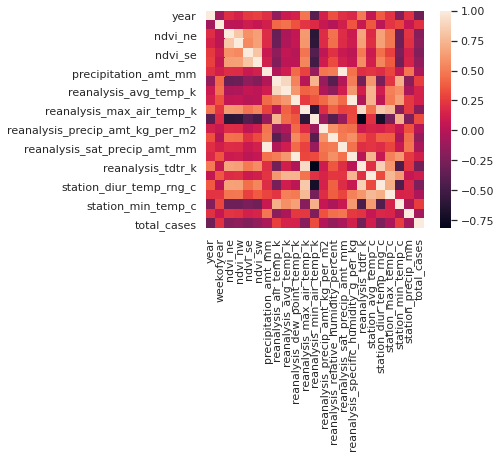

In [27]:
import seaborn as sns

sns.set()
sns.heatmap(train.corr(), square=True, annot=False)

In [0]:
lb = preprocessing.LabelBinarizer()
train['city_bin'] = lb.fit_transform(train['city'])

train.drop(['city'], axis = 1, inplace=True)
train.drop(['year'], axis = 1, inplace=True)

In [42]:
k = 15
columnas = list(train.drop(['total_cases'], axis=1).columns.values)
seleccionadas = SelectKBest(f_regression, k = k).fit(train.drop(['total_cases'], axis=1), train['total_cases'])
atrib = seleccionadas.get_support()
atributos = [columnas[i] for i in list(atrib.nonzero()[0])]
atributos

['weekofyear',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_relative_humidity_percent',
 'reanalysis_tdtr_k',
 'station_diur_temp_rng_c',
 'station_min_temp_c',
 'city_bin']

In [0]:
selected_features = atributos.copy()
selected_features.append('total_cases')
train2 = train[selected_features]

Min Value uniform : 18.760056117146902 (25)
Min Value distance : 18.73722355972753 (25)


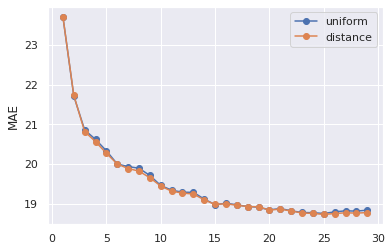

In [44]:
cv = KFold(n_splits = 10, shuffle = False) #
# se podría utilizar https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html 

for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(train2):
          # División train test aleatoria
          f_train = train2.loc[train_fold]
          f_test = train2.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(['total_cases'], axis=1), 
                               y = f_train['total_cases'])
          y_pred = knn.predict(X = f_test.drop(['total_cases'], axis = 1))
          # evaluación del modelo
          mae = mean_absolute_error(f_test['total_cases'], y_pred)
          fold_accuracy.append(mae)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')      
    

plt.legend()
plt.show() 


Como podemos observar, los valores con ambos pesos son prácticamente iguales. Probamos con el k del mínimo error de cada peso y lo subimos a la competición.
Como comenté anteriormente con el DecisionTree, sería muy interesante probar con distintos valores de k y distinto peso ya que son prácticamente iguales y podríamos obtener mejores resultados en la competición que con estos valores.

In [32]:
test = upload_files()
test.head()

Saving dengue_features_test.csv to dengue_features_test (2).csv
User uploaded file "dengue_features_test.csv" with length 82465 bytes


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [33]:
test.fillna(method='ffill', inplace=True)
pd.isnull(test).any()

city                                     False
year                                     False
weekofyear                               False
week_start_date                          False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_t

In [0]:
test.drop("week_start_date", axis = 1, inplace = True)

In [0]:
lb = preprocessing.LabelBinarizer()
test['city_bin'] = lb.fit_transform(test['city'])

test.drop(['city'], axis = 1, inplace=True)
test.drop(['year'], axis = 1, inplace=True)

selected_features.pop()
test = test[selected_features]

In [36]:
# constructor
n_neighbors = 25
weights = 'uniform'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights) 
# fit and predict

knn.fit( X = train2.drop(['total_cases'], axis=1), y = train['total_cases'])
y_pred = knn.predict(X = test)

# round the result and cast to int
res = np.rint(y_pred) # round
res = res.astype(int) # cast to int
res

array([11, 11, 12, 10, 11, 13, 17, 19, 16, 24, 15, 26, 28, 42, 38, 46, 37,
       26, 42, 41, 51, 70, 59, 72, 57, 56, 70, 64, 51, 35, 27, 29, 32, 37,
       30, 27, 27, 26, 30, 32, 19, 19, 13, 15, 12, 10, 12,  8,  9,  8, 10,
       10, 10, 11,  8,  8, 15, 12, 13, 16, 20, 24, 21, 31, 26, 32, 48, 49,
       41, 50, 65, 59, 63, 48, 52, 49, 45, 44, 69, 64, 44, 42, 66, 23, 34,
       34, 36, 36, 35, 30, 39, 31, 19, 18, 19, 20, 21, 19, 18, 12, 11, 10,
       10, 12, 11, 13, 14, 11, 12, 22, 15, 22, 21, 22, 32, 28, 42, 35, 41,
       48, 51, 44, 47, 43, 35, 45, 58, 50, 45, 59, 71, 59, 64, 54, 27, 33,
       29, 38, 37, 31, 31, 34, 30, 30, 23, 20, 17, 21, 17, 16, 14, 10, 16,
       12, 10, 10,  8, 11, 10, 10, 14, 16, 14, 24, 24, 29, 28, 40, 34, 61,
       51, 68, 39, 56, 50, 58, 69, 75, 43, 51, 50, 76, 72, 42, 55, 68, 66,
       52, 33, 49, 28, 26, 26, 30, 23, 26, 19, 22, 21, 18, 17, 22, 19, 10,
       15, 14, 11, 11,  8, 10,  9, 13, 14, 11, 15, 18, 19, 22, 29, 31, 32,
       52, 34, 53, 49, 43

In [37]:
test = upload_files()
test.head()

Saving dengue_features_test.csv to dengue_features_test (3).csv
User uploaded file "dengue_features_test.csv" with length 82465 bytes


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [38]:
# generate output
output = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': res})


from google.colab import files

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('result.csv')

output.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,11
1,sj,2008,19,11
2,sj,2008,20,12
3,sj,2008,21,10
4,sj,2008,22,11


In [0]:
Con k = 25 y weight = uniform he obtenido un resultado de 26.1538
Con k = 25 y weight = distance he obtenido un resultado de 26.0072

Como comentaba, vemos que con los datos de test también son muy parecidos ambos pesos para el mismo k por lo que sería muy interesante probar con diferentes valores de k.